In [2]:
from utils.utils import calculate_attributions
import matplotlib.pyplot as plt 
import numpy as np

In [4]:
import pandas as pd
import numpy as np
dataset = "GunPoint"
task  = 'task_1'


output_directory = f'G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/{dataset}/fcn/fcn_itr_/original/'
att_train = np.load(output_directory + f"calculated_attribution_train_{task}.npy",allow_pickle=True)
att_test = np.load(output_directory + f"calculated_attribution_test_{task}.npy",allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_itr_/original/calculated_attribution_train_task_1.npy'

In [7]:
root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'
classifier = 'fcn_itr_'
#classifier = 'fcn_mt_dense_itr_'
dataset_name =  'GunPoint'
data_source = 'original'
mode = 'stl'

from utils.utils import read_dataset

def calculate_att(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1):
    #import tensorflow_addons as tfa
    import tensorflow.keras as keras
    import sklearn
    import os

    max_length = 2000
    
    if task == 1: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name,  'original')
    elif task == 2: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name,   data_source)
        
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()
    
    orgx_train = x_train
    orgx_test = x_test
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    
    print(f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5')
    model = keras.models.load_model( f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5',compile=False)

    if mode == 'stl': 
        relu, softm = (-3,-1)
    if mode == 'mtl': 
        relu, softm = (3,-2)
    #print(model.layers[relu])
    w_k_c = model.layers[softm].get_weights()[0]  # weights for each filter k for each class c
        
    # the same input
    new_input_layer = model.inputs
    new_output_layer = [model.layers[relu].output, model.layers[softm].output]
    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)
    output = []

    for orgx_vals,x_vals,y_vals in [[orgx_train,x_train,y_train],[orgx_test,x_test,y_test]]:
        attr = list()
        for idx,ts in enumerate(x_vals):
            ts = ts.reshape(1, -1, 1)
            [conv_out, predicted] = new_feed_forward([ts])
            cas = np.zeros(dtype=np.float64, shape=(conv_out.shape[1]))
            for k, w in enumerate(w_k_c[:,int(y_vals[idx]-1)]):
                cas += w * conv_out[0, :, k] 
            attr.append([y_vals,orgx_vals[idx],cas])
        output.append(attr)
    return output
att_train,att_test = calculate_att(root_dir, archive_name, classifier,  dataset_name, data_source, mode, task=1)

"/content/drive/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5"

G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5


'/content/drive/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5'

In [8]:
import tensorflow.keras as keras
att = calculate_att(root_dir, archive_name, classifier,  dataset_name, data_source, mode, task=1)

G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5


In [9]:
len(att[0]), len(att[1])

(50, 150)

In [11]:
path = 'G:/Meine Ablage/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_mt_ae_itr_/pointwise/best_model.hdf5'
model = keras.models.load_model(path,compile=False)

SHAPE (150,)


2

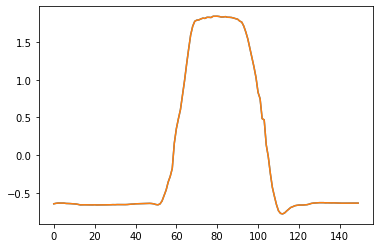

In [76]:
from utils.utils import read_dataset
plt.plot(att[0][0][1])
x = att[0][0][1]
data_p = 'G:/My Drive/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'GunPoint'
data_source = ''
xt = read_dataset(data_p, archive_name, dataset_name,  data_source)['GunPoint'][0]
plt.plot(xt[0])
print("SHAPE",xt[0,:].flatten().shape)
pred = model.predict(xt)
len(pred[0][1])

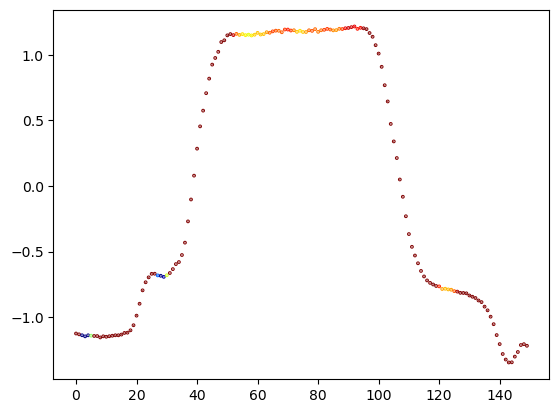

In [12]:
%matplotlib inline

plt.scatter(np.arange(len(att_test[0][1])),att_test[0][1],c=att_test[0][2]*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)

In [90]:
def create_pointwise_explanation(attributions):
    output = []
    for split in attributions:
        explanations = []
        for ts in split: 
            x_values = ts[1]
            attributions = ts[2]
            explanations.append(np.concatenate((np.array([x_values]),attributions), axis=None))    
        output.append(np.array(explanations))
    return output

create_pointwise_explanation(att)[0][:,150:].shape


(50, 150)

In [159]:
def save_explanations(data, root_dir, archive_name, appendix, dataset_name):
    train_explanation,test_explanation = data
    print(train_explanation.shape, test_explanation.shape)
    dir_path = root_dir + '/archives/' + archive_name + '/' + dataset_name + '/' + appendix + '/' 
    create_directory(dir_path)
    np.savetxt(dir_path + dataset_name + "_TRAIN", train_explanation, delimiter=',')
    np.savetxt(dir_path + dataset_name + "_TEST", test_explanation, delimiter=',')
    print("Successfully created explanation done.")

In [82]:
#G:\My Drive\master thesis\code\xai-tsc\results\ucr\GunPoint\fcn\fcn_mt_ae_itr_\pointwise\last_model.hdf5

model05 = keras.models.load_model("G:/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_mt_ae_itr_0.5/pointwise/best_model.hdf5",compile=False)

In [83]:
model00 = keras.models.load_model("G:/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_mt_ae_itr_0/pointwise/best_model.hdf5",compile=False)

In [90]:
modeld = keras.models.load_model("G:/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_mt_dense_itr_/pointwise/best_model.hdf5",compile=False)

In [95]:


x = data[:, :150]
y_att = data[:,150:]

pred_ts_0 = model05.predict(data[:,150:][:3])[1][0].flatten()
pred_ts_0s = model00.predict(data[:,150:][:3])[1][0].flatten()
pred_ts_0d = modeld.predict(data[:,150:][:3])[1][0].flatten()
np.corrcoef(y_att[ts],pred_ts_0),np.corrcoef(y_att[ts],pred_ts_0s),np.corrcoef(y_att[ts],pred_ts_0d)

(array([[ 1.        , -0.12093848],
        [-0.12093848,  1.        ]]),
 array([[ 1.        , -0.07191523],
        [-0.07191523,  1.        ]]),
 array([[1.       , 0.5820025],
        [0.5820025, 1.       ]]))

0.385416684769506 0.27306478888195385 0.6486186062184436


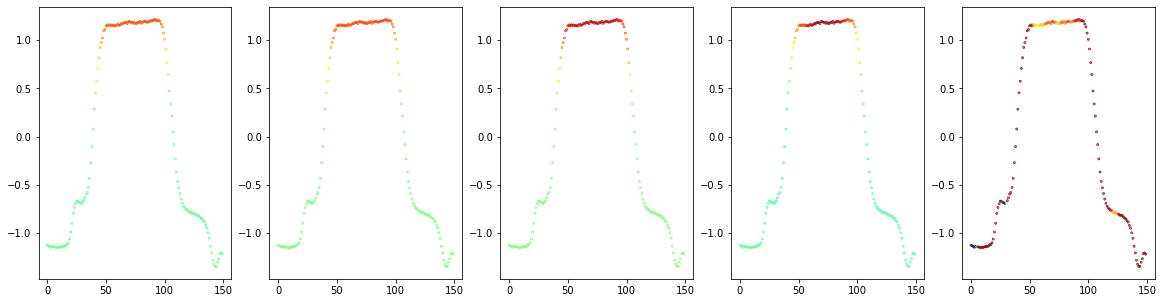

In [128]:
%matplotlib inline
ts = 0
#plt.plot(x[ts],c="red")
y_pred = model05.predict(x)[1][0].flatten()
y_pred0 = model00.predict(x)[1][0].flatten()
y_predd = modeld.predict(x)[1][0].flatten()
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
print(np.corrcoef(y_att[ts],pred_ts_0)[1][0],np.corrcoef(y_att[ts],pred_ts_0s)[1][0],np.corrcoef(y_att[ts],pred_ts_0d)[1][0])

axes[0].scatter(np.arange(len(x[ts])),x[ts],c=y_att[ts]*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)
axes[1].scatter(np.arange(len(x[ts])),x[ts],c=y_pred*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)
axes[2].scatter(np.arange(len(x[ts])),x[ts],c=y_pred0*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)
axes[3].scatter(np.arange(len(x[ts])),x[ts],c=y_predd*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)
axes[4].scatter(np.arange(len(att_test[0][1])),att_test[0][1],c=att_test[0][2]*100,cmap='jet', marker='.', s=2, vmin=-100, vmax=100, linewidths=2.0)

In [134]:
data[:, 150:].shape

(150, 150)

In [94]:
og = data = np.loadtxt("G:/My Drive/master thesis/code/xai-tsc/archives/ucr/GunPoint/GunPoint_TEST", delimiter=',')
data = np.loadtxt("G:/My Drive/master thesis/code/xai-tsc/archives/ucr/GunPoint/pointwise/GunPoint_TEST", delimiter=',')
print(data[:, 150:].shape)

(150, 150)


In [138]:
og[:,1:].shape

(150, 150)

In [12]:
print(data[:, 150:])

NameError: name 'data' is not defined